In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.PINN.train_PINN import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset(2**12, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders(data, 512)

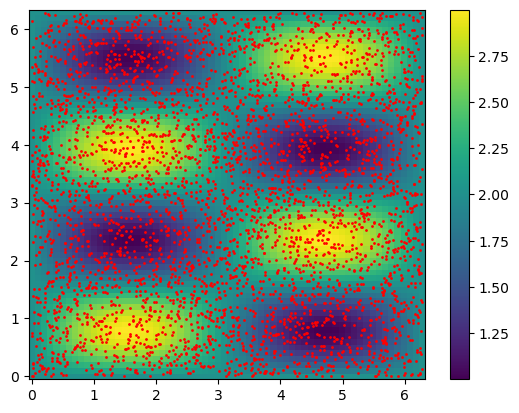

In [3]:
L = 2*np.pi
N = 64 # number of nodes in each direction including the border
H1 = torch.tensor([1, 0], device=dev).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
def a_function(x,y):
    a = 2+np.sin(x)*np.sin(2*y)
    return a
def A(x):
    a = (2+torch.sin(x[:,0])*torch.sin(2*x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 1, c='r')

In [7]:
args = {'lr' : 0.00001, 'epochs' : 2000, 'dev' : dev, 'name' : 'NN_library/PINN/PINN_H1'}
net_H1 = PINN(n_periodic=10, n_hidden=30, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5411


In [10]:
net_H1 = load_network(net_H1, args['name']+'', args)
net_H1 = net_H1.to(dev)

In [ ]:
losses_train, losses_val = train(net_H1, loaders, args, A, H1)

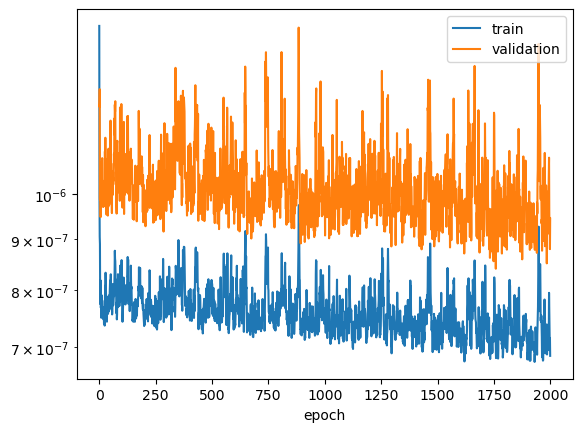

In [129]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [4]:
args = {'lr' : 0.00001, 'epochs' : 10000, 'dev' : dev, 'name' : 'NN_library/PINN/PINN_H2'}
net_H2 = PINN(n_periodic=10, n_hidden=30, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_H2.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5411


In [ ]:
net_H2 = load_network(net_H2, args['name']+'', args)

In [5]:
losses_train, losses_val = train(net_H2, loaders, args, A, H2)

Epoch: 0 mean train loss:  1.58386431e+00, mean val. rec. loss:  1.47427696e+00
Epoch: 1 mean train loss:  1.55549607e+00, mean val. rec. loss:  1.44759998e+00
Epoch: 2 mean train loss:  1.52882973e+00, mean val. rec. loss:  1.42224330e+00
Epoch: 3 mean train loss:  1.50464187e+00, mean val. rec. loss:  1.39770210e+00
Epoch: 4 mean train loss:  1.48053888e+00, mean val. rec. loss:  1.37479427e+00
Epoch: 5 mean train loss:  1.45829201e+00, mean val. rec. loss:  1.35325794e+00
Epoch: 6 mean train loss:  1.43714695e+00, mean val. rec. loss:  1.33304190e+00
Epoch: 7 mean train loss:  1.41708715e+00, mean val. rec. loss:  1.31407754e+00
Epoch: 8 mean train loss:  1.39859094e+00, mean val. rec. loss:  1.29600190e+00
Epoch: 9 mean train loss:  1.38102044e+00, mean val. rec. loss:  1.27881991e+00
Epoch: 10 mean train loss:  1.36428960e+00, mean val. rec. loss:  1.26254853e+00
Epoch: 11 mean train loss:  1.34824113e+00, mean val. rec. loss:  1.24729659e+00
Epoch: 12 mean train loss:  1.33302303

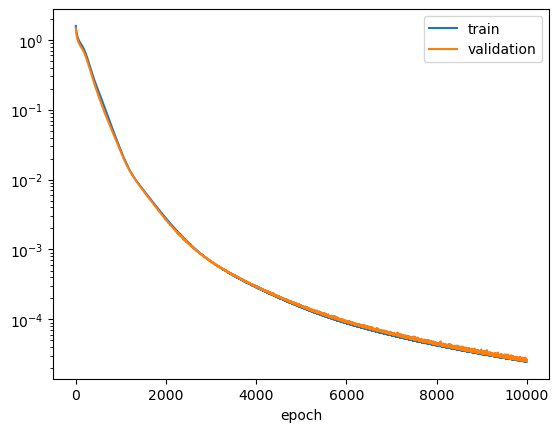

In [15]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [11]:
U1 = net_H1(grid_data)
U2 = net_H2(grid_data)

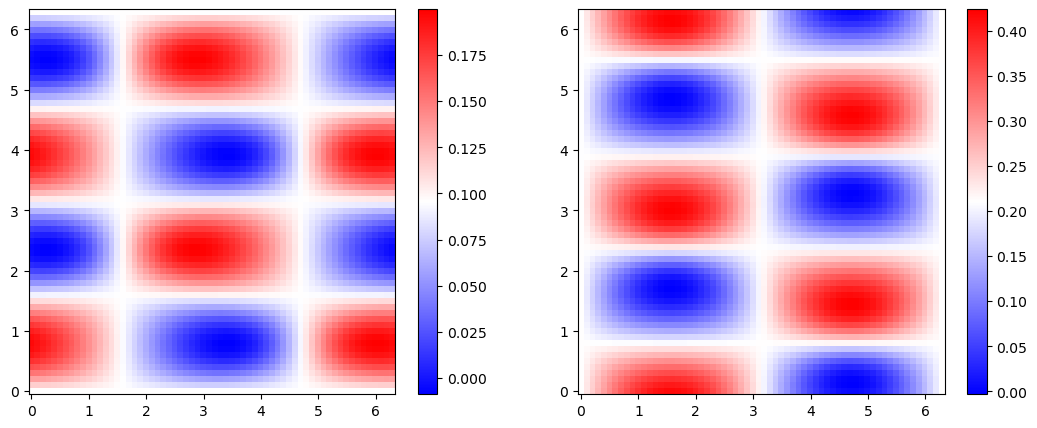

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N).detach().cpu(), cmap='bwr')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], U2.reshape(N, N).detach().cpu(), cmap='bwr')
fig.colorbar(pos2, ax=axs[1])